# AST 384C - Computational Astrophysics - HW 1
## Carlos Jurado

In [1]:
# Python package imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import timeit
from tqdm import tqdm
import time

# Loading in style file for plots
plt.style.use('/Users/caj3577/Desktop/plotting.mplstyle')

# Problem 1

The standard Kepler problem is the bound orbit of a test particle around a body of mass M. The
equations are:

$$ 
\boldsymbol{\dot{r}} = \boldsymbol{v}
$$

$$
\boldsymbol{\dot{v}} = \frac{GM}{r^3}\boldsymbol{r}
$$

where r = (x, y) and v = (vx, vy). Initialize the system with the particle at (0, rp ) with velocity
(−vp, 0), which puts the particle moving counterclockwise with velocity vp at pericenter rp.

For this homework, assume the orbit is that of a planet at the Earth-Sun separation (a = 1 AU)
around central mass with M = 1 M⊙

- Implement a 4th-order Runge-Kutta solver with fixed timestep to solve the Kepler problem.
First, apply this to a circular orbit (e = 0) over a 1 year period. Compare results for a
timestep of 1 month (1/12 of a period), 1 week (you can approximate this as 1/48 of a
period for this exercise), and 1 day (1/365.25 of a period). Relative to the initial value, how
does the error in the final position depend on the timestep? How about the error in the
energy?

In [2]:
class KeplerOrbit:
    ''' 
    Sets-up and tracks a particle in a Keplerian orbit and it's subsequent time evolution. 

    Attributes:
        state (np.array): The current phase-space state vector in cartesian coordinates -- [x,y,vx,vy]
        GM (float): Gravitational Constant multiplied by the mass of the central body ( [M] in Solar Masses, [T] in Years, [L] in AU )
        state_history (np.arry): A (N,4,1) np.array of all previous and the current phase-state vectors at a given time

    Methods:
    
        __init__ 
            Initializes a KeplerOrbit object with state and GM attributes.         
             

        specfic_energy
            Calculates the specific energy of the orbiting body at the current state

            Return: (float)


        positional_derivative: 
            Calculates the velocity of the orbiting body at the current state

            Parameters:
                State ( np.array of shape (4,1) ): The current phase-space state of the particle

            Return: ( np.array of shape (2,1) )

            
        velocity_derivative: 
            Calculates the acceleration of the orbiting body at the current state

            Parameters:
                State ( np.array of shape (4,1) ): The current phase-space state of the particle

            Return: ( np.array of shape (2,1) )

            
        RK4: 
            Fourth-order Runge-Kutta Implementation to track a point-mass particle's trajectory.
            At the end of one iteration, the current state and history of the object is updated. 
            
            Parameters: 
                dt: The amount of time to evolve the system forward 
                N: The number of intervals to evavluate the particle's position at 

        
        xyvxvy_history: 
            Splits the state_history variable into separate components for each coordinate (x,y,vx,vz) 

        Return: (    np.array of Shape (N), np.array of Shape (N), np.array of Shape (N), np.array of Shape (N)    )          
    '''


    def __init__(self, initial_state, GM):
        self.state = np.array(initial_state, dtype=np.float64)
        self.GM = GM
        self.state_history = [self.state]


    def specific_energy(self):
        position_arr, velocity_arr = self.state[0:2], self.state[2:] #Splits state vector into a position vector and velocity vector

        r = np.sqrt(position_arr[0]**2 + position_arr[1]**2) #radius of the particle from the central body
        v = np.sqrt(velocity_arr[0]**2 + velocity_arr[1]**2) #speed of the particle 

        return 0.5*(v**2) - (self.GM)/r #Total Energy


    def positional_derivative(self, state): 
        return state[2:] #dx/dt = v
    
     
    def velocity_derivative(self, state):
        r = np.sqrt( state[0]**2 + state[1]**2  ) #radius of the particle from the central body
        return -self.GM/(r**3) * state[0:2] # Vector form: dv/dt = -GM/r^3 <x, y> 


    def xyvxvy_history(self):
        state_array = np.array(self.state_history)
        
        # Split the array into separate components
        x_history = state_array[:, 0]
        y_history = state_array[:, 1]
        vx_history = state_array[:, 2]
        vy_history = state_array[:, 3]
        
        return x_history, y_history, vx_history, vy_history




    def RK4(self, N, start_time, end_time):
        dt = (end_time - start_time)/N
        for i in range(N):

            k1vel = dt*self.velocity_derivative(self.state) 
            k1pos = dt*self.positional_derivative(self.state)
            
            k2vel = dt*self.velocity_derivative( self.state + 0.5*np.concatenate( (k1pos, k1vel), axis=0 ) )
            k2pos = dt*self.positional_derivative( self.state + 0.5*np.concatenate( (k1pos, k1vel), axis=0 ) )

            k3vel = dt*self.velocity_derivative( self.state + 0.5*np.concatenate( (k2pos, k2vel), axis=0 ) )
            k3pos = dt*self.positional_derivative( self.state + 0.5*np.concatenate( (k2pos, k2vel), axis=0 ) )

            k4vel = dt*self.velocity_derivative( self.state + np.concatenate( (k3pos, k3vel), axis=0 ) )
            k4pos = dt*self.positional_derivative( self.state + np.concatenate( (k3pos, k3vel), axis=0 ) )


            k1 = np.concatenate((k1pos, k1vel)) #Creating a (4,1) np.array that holds the ks for velocity and position updates
            k2 = np.concatenate((k2pos, k2vel))
            k3 = np.concatenate((k3pos, k3vel))
            k4 = np.concatenate((k4pos, k4vel))

            self.state += (1/6)*(k1+2*k2+2*k3+k4) #update state of the particle according to the 4th order Runge-Kutta weighing
            self.state_history.append(self.state.copy()) #append current state to history



    def RK4_Adaptive_TimeStepping(self, N, start_time, end_time, precision):
        dt = (end_time - start_time)/N        
        for i in range(N):

            k1vel = dt*self.velocity_derivative(self.state) 
            k1pos = dt*self.positional_derivative(self.state)
            
            k2vel = dt*self.velocity_derivative( self.state + 0.5*np.concatenate( (k1pos, k1vel), axis=0 ) )
            k2pos = dt*self.positional_derivative( self.state + 0.5*np.concatenate( (k1pos, k1vel), axis=0 ) )

            k3vel = dt*self.velocity_derivative( self.state + 0.5*np.concatenate( (k2pos, k2vel), axis=0 ) )
            k3pos = dt*self.positional_derivative( self.state + 0.5*np.concatenate( (k2pos, k2vel), axis=0 ) )

            k4vel = dt*self.velocity_derivative( self.state + np.concatenate( (k3pos, k3vel), axis=0 ) )
            k4pos = dt*self.positional_derivative( self.state + np.concatenate( (k3pos, k3vel), axis=0 ) )

            #Creating a (4,1) np.array that holds the ks for velocity and position updates
            k1,k2,k3,k4 = np.concatenate((k1pos, k1vel)), np.concatenate((k2pos, k2vel)), np.concatenate((k3pos, k3vel)), np.concatenate((k4pos, k4vel))


In [3]:
def velocity_peri(GM, a, e): 
    ''' 
    Calculates velocity of a point particle at perihelion 
    '''
    return np.sqrt(GM/a) * np.sqrt( (1+e)/(1-e) )


def specific_energy(GM, state):
    ''' 
    Calculates the specific energy of a particle
    '''
    position_arr, velocity_arr = state[0:2], state[2:] #Splits state vector into a position vector and velocity vector

    r = np.sqrt(position_arr[0]**2 + position_arr[1]**2) #radius of the particle from the central body
    v = np.sqrt(velocity_arr[0]**2 + velocity_arr[1]**2) #speed of the particle 

    return 0.5*(v**2) - (GM)/r #Total Energy



In [4]:

#Initial Condtion Setup
###
a = 1
e_initial_circ = 0
rp_intial_circ = 1 * (1-e_initial_circ)
GM = 4 * np.pi**2 
start_time, end_time = 0,1
###


#Initial State Setup
###
v_initial_circ = - velocity_peri(GM, a, e_initial_circ)
initial_state = np.array([0,rp_intial_circ,v_initial_circ,0])  
intial_energy = specific_energy(GM, initial_state)
###


'''
N_12 = 12 # number of intervals
orbitN12 = KeplerOrbit(initial_state, GM=4*np.pi**2) #Initialize orbit
orbitN12.RK4(N_12, start_time, end_time) #Integrate orbit
dynamical_historyN12 = orbitN12.xyvxvy_history() #Access state vector at each time step
'''


N_values = [12, 48, 365]  # Array of N values to explore. Here each N refers to the numbers of steps taken in 1 year
orbit_histories = {}  
energy_histories = {}  


for N in N_values:
    orbit = KeplerOrbit(initial_state, GM)  # Reset the orbit for each N
    orbit.RK4(N, start_time, end_time)  # Evolve the system
    orbit_histories[N] = orbit.xyvxvy_history()  # Store the position history
    energy_histories[N] = orbit.specific_energy()  # Stores the energy of the orbit at the current state (End of RK4 integration)

In [5]:
### Error Calculations

#Error between initial and final position 
positional_err = {}
for N in N_values: 
    positional_err[N] = np.abs(orbit_histories[N][1][-1]/initial_state[1] - 1) #relative error = (final_val - initial_val)/initial_val = final_val/inital_val - 1


#Error between initial and final energy 
energy_err = {}
for N in N_values: 
    energy_err[N] = np.abs(energy_histories[N]/intial_energy - 1)

Text(0.5, 1.0, 'Error in Energy After A Full Orbit')

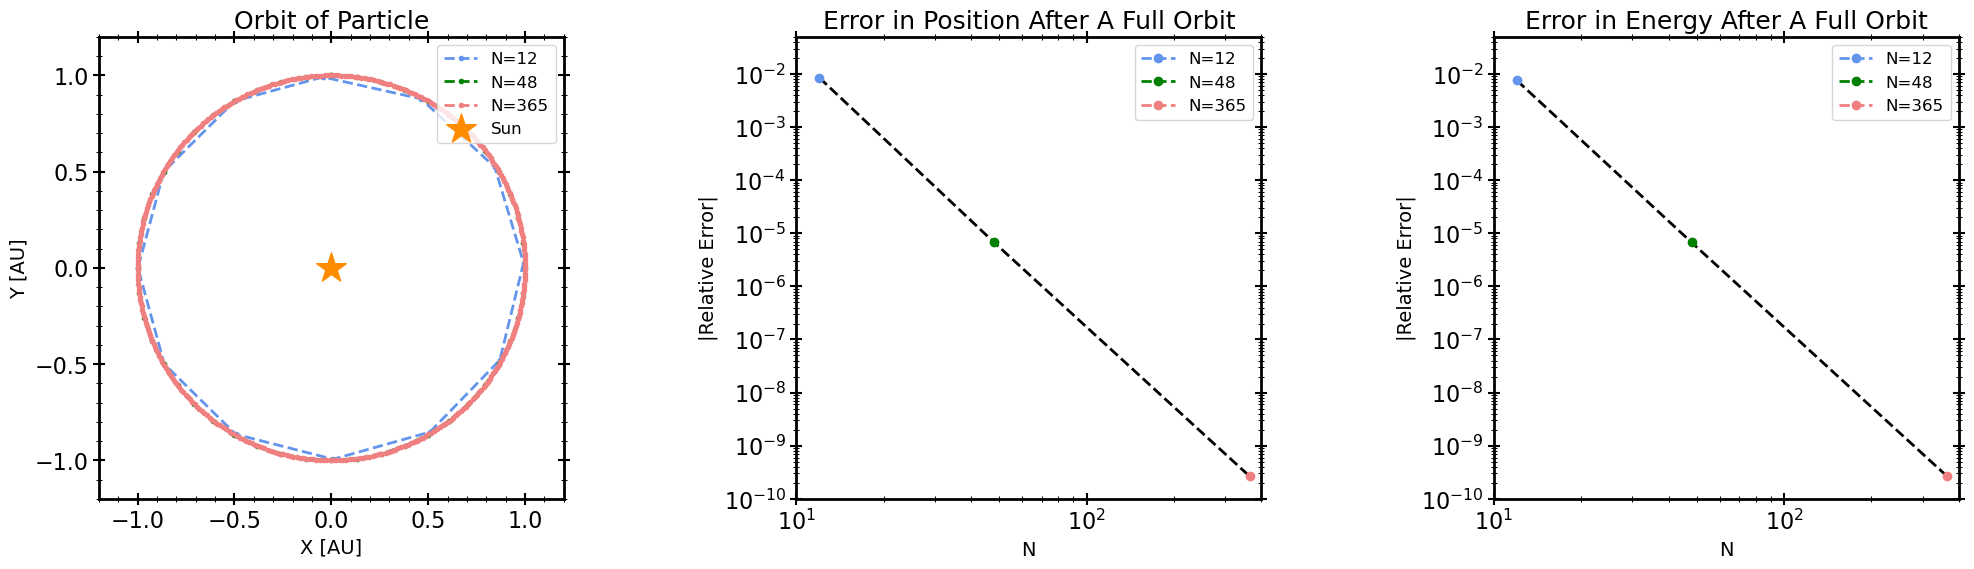

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(24, 6))
plt.subplots_adjust(wspace=0.5, hspace=0.3)


axs[0].plot(orbit_histories[12][0], orbit_histories[12][1], color='cornflowerblue', marker='.', label='N=12', linestyle = '--')
axs[0].plot(orbit_histories[48][0], orbit_histories[48][1], color='green', marker='.', label='N=48', linestyle = '--')
axs[0].plot(orbit_histories[365][0], orbit_histories[365][1], color='lightcoral', marker='.', label='N=365', linestyle = '--')
axs[0].scatter(0, 0, marker = '*', color = 'darkorange', s=500, label='Sun')

axs[0].set_xlabel('X [AU]')
axs[0].set_xlim(-1.2, 1.2)
axs[0].set_ylabel('Y [AU]')
axs[0].set_ylim(-1.2, 1.2)
axs[0].legend(ncol=1, loc='upper right')
axs[0].set_title("Orbit of Particle")






axs[1].loglog(N_values, [positional_err[12], positional_err[48], positional_err[365]], color='black', linestyle = '--')
axs[1].loglog(N_values[0], positional_err[12], color='cornflowerblue', marker='o', label='N=12', linestyle = '--')
axs[1].loglog(N_values[1], positional_err[48], color='green', marker='o', label='N=48', linestyle = '--')
axs[1].loglog(N_values[2], positional_err[365], color='lightcoral', marker='o', label='N=365', linestyle = '--')
axs[1].legend(ncol=1, loc='upper right')

axs[1].set_xlabel('N')
axs[1].set_xlim(10**1, 4 * 10**2)
axs[1].set_ylabel('|Relative Error|')
axs[1].set_ylim(10**-10, 5 * 10**-2)
axs[1].set_title("Error in Position After A Full Orbit")







axs[2].loglog(N_values, [energy_err[12], energy_err[48], energy_err[365]], color='black', linestyle = '--')
axs[2].loglog(N_values[0], energy_err[12], color='cornflowerblue', marker='o', label='N=12', linestyle = '--')
axs[2].loglog(N_values[1], energy_err[48], color='green', marker='o', label='N=48', linestyle = '--')
axs[2].loglog(N_values[2], energy_err[365], color='lightcoral', marker='o', label='N=365', linestyle = '--')
axs[2].legend(ncol=1, loc='upper right')

axs[2].set_xlabel('N')
axs[2].set_xlim(10**1, 4 * 10**2)
axs[2].set_ylabel('|Relative Error|')
axs[2].set_ylim(10**-10, 5 * 10**-2)
axs[2].set_title("Error in Energy After A Full Orbit")

- Now repeat the exercise for an orbit with (e = 0.96) over the same year period. How do
your results differ?

In [7]:

#Initial Condtion Setup
###
e_initial_ellip = 0.96
rp_intial_ellip = 1 * (1-e_initial_ellip)
GM = 4 * np.pi**2 
start_time, end_time = 0,1
###


#Initial State Setup
###
v_initial_ellip = - velocity_peri(GM, a, e_initial_ellip)
initial_state_ellip = np.array([0,rp_intial_ellip,v_initial_ellip,0])  
intial_energy_ellip = specific_energy(GM, initial_state_ellip)
###

In [8]:
orbit_histories_ellip = {}  
energy_histories_ellip = {}  

for N in N_values:
    orbit = KeplerOrbit(initial_state_ellip, GM)  # Reset the orbit for each N
    orbit.RK4(N, start_time, end_time)  # Evolve the system
    orbit_histories_ellip[N] = orbit.xyvxvy_history()  # Store the position history
    energy_histories_ellip[N] = orbit.specific_energy()  # Stores the energy of the orbit at the current state (End of RK4 integration)

In [9]:
### Error Calculations

#Error between initial and final position 
positional_err_ellip = {}
for N in N_values: 
    positional_err_ellip[N] = np.abs(orbit_histories_ellip[N][1][-1]/initial_state_ellip[1] - 1) #relative error = (final_val - initial_val)/initial_val = final_val/inital_val - 1


#Error between initial and final energy 
energy_err_ellip = {}
for N in N_values: 
    energy_err_ellip[N] = np.abs(energy_histories_ellip[N]/intial_energy_ellip - 1)

Text(0.5, 1.0, 'Error in Final Energy After A Full Orbit (e=0.96)')

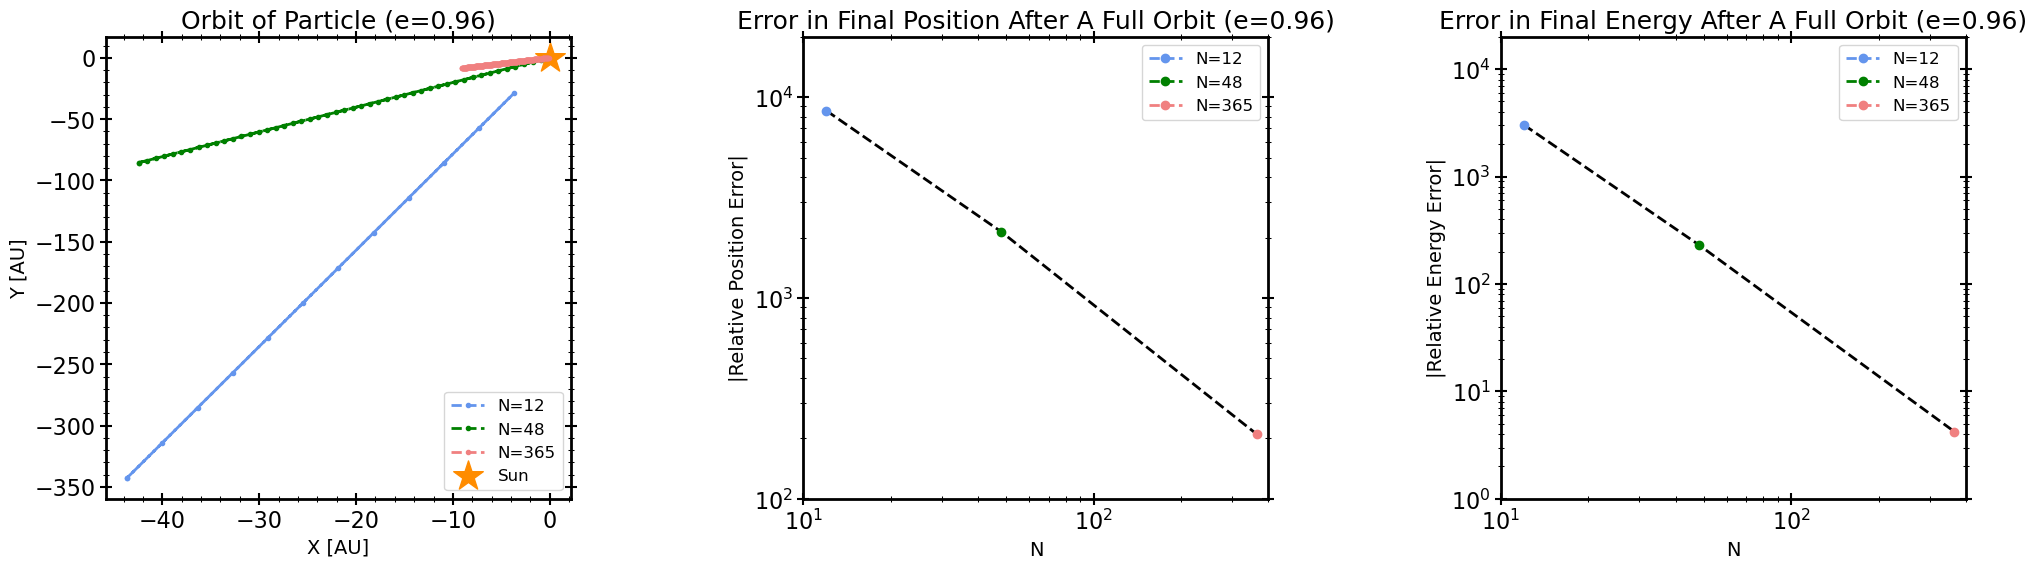

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(24, 6))
plt.subplots_adjust(wspace=0.5, hspace=0.3)


axs[0].plot(orbit_histories_ellip[12][0], orbit_histories_ellip[12][1], color='cornflowerblue', marker='.', label='N=12', linestyle = '--')
axs[0].plot(orbit_histories_ellip[48][0], orbit_histories_ellip[48][1], color='green', marker='.', label='N=48', linestyle = '--')
axs[0].plot(orbit_histories_ellip[365][0], orbit_histories_ellip[365][1], color='lightcoral', marker='.', label='N=365', linestyle = '--')
axs[0].scatter(0, 0, marker = '*', color = 'darkorange', s=500, label='Sun')

axs[0].set_xlabel('X [AU]')
#axs[0].set_xlim(-1.2, 1.2)
axs[0].set_ylabel('Y [AU]')
#axs[0].set_ylim(-1.2, 1.2)
axs[0].legend(ncol=1, loc='lower right')
axs[0].set_title("Orbit of Particle (e=0.96)")






axs[1].loglog(N_values, [positional_err_ellip[12], positional_err_ellip[48], positional_err_ellip[365]], color='black', linestyle = '--')
axs[1].loglog(N_values[0], positional_err_ellip[12], color='cornflowerblue', marker='o', label='N=12', linestyle = '--')
axs[1].loglog(N_values[1], positional_err_ellip[48], color='green', marker='o', label='N=48', linestyle = '--')
axs[1].loglog(N_values[2], positional_err_ellip[365], color='lightcoral', marker='o', label='N=365', linestyle = '--')
axs[1].legend(ncol=1, loc='upper right')

axs[1].set_xlabel('N')
axs[1].set_xlim(10**1, 4 * 10**2)
axs[1].set_ylabel('|Relative Position Error|')
axs[1].set_ylim(10**2, 2* 10**4)
axs[1].set_title("Error in Final Position After A Full Orbit (e=0.96)")







axs[2].loglog(N_values, [energy_err_ellip[12], energy_err_ellip[48], energy_err_ellip[365]], color='black', linestyle = '--')
axs[2].loglog(N_values[0], energy_err_ellip[12], color='cornflowerblue', marker='o', label='N=12', linestyle = '--')
axs[2].loglog(N_values[1], energy_err_ellip[48], color='green', marker='o', label='N=48', linestyle = '--')
axs[2].loglog(N_values[2], energy_err_ellip[365], color='lightcoral', marker='o', label='N=365', linestyle = '--')
axs[2].legend(ncol=1, loc='upper right')

axs[2].set_xlabel('N')
axs[2].set_xlim(10**1, 4 * 10**2)
axs[2].set_ylabel('|Relative Energy Error|')
axs[2].set_ylim(10**0, 2* 10**4)
axs[2].set_title("Error in Final Energy After A Full Orbit (e=0.96)")

- Next, update your fourth-order RK solver to use adaptive timesteps. As a reminder, we
can do this by evolving from y(t) →y(t + τ) with a fixed timestep τ (call this yτ ), then with
two steps of size τ/2 (call this y2(τ/2)), and comparing the relative error of the solution at
y(t + τ):

$$ 
\epsilon = |\left(1 - \frac{y_{\tau}}{y_{2(\tau/2)}}       \right)|
$$

The estimate for timestep that will give us our desired accuracy (εgoal) is

$$ 
\tau_{est} = \tau\left(\frac{\epsilon_{goal}}{\epsilon_{ref}} \right)
$$

because ε ∝τ5 for fourth-order Runge-Kutta. If εrel ≤εgoal, then we adopt the timestep,
store the solution at time t + τ/2 + τ/2 (i.e., use the solution with the smaller of the two
timesteps we tried in this iteration), and change to τ = τest for our next step (increase the
timestep). If εrel >εgoal, we discard the solution we got for y(t + τ) and retry the
integration at y(t) with τ = τest (decrease the timestep).
Apply this new time-stepping routine to the e = 0.96 case above, starting with an initial
timestep of one month and requiring a relative error of εgoal = 10−5. Plot the orbit so that
we can see the individual timesteps and separately plot how the timestep evolves over the
course of the orbit. How many timesteps did you have to take? How well is energy
conserved? Now try for 25 orbits. How does the energy evolve? Would this be a good way
to do accurate planetary orbit calculations over the age of the Solar System?
2